<a href="https://colab.research.google.com/github/ArpitRawat07/DeepLearning_ImageClassification/blob/main/Transfer_Learning_Food101_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [2]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-12 13:36:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.207, 142.251.6.207, 108.177.111.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   254MB/s    in 6.1s    

2024-01-12 13:36:35 (253 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images

In [4]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


In [6]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

### Feature Extraction model

In [7]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [8]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [9]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 162s 629ms/step - loss: 3.3633 - accuracy: 0.2820 - val_loss: 2.5561 - val_accuracy: 0.4229
Epoch 2/5
237/237 [==============================] - 110s 464ms/step - loss: 2.1894 - accuracy: 0.4980 - val_loss: 2.0735 - val_accuracy: 0.4886
Epoch 3/5
237/237 [==============================] - 92s 385ms/step - loss: 1.8175 - accuracy: 0.5666 - val_loss: 1.9342 - val_accuracy: 0.5056
Epoch 4/5
237/237 [==============================] - 90s 376ms/step - loss: 1.5925 - accuracy: 0.6170 - val_loss: 1.8481 - val_accuracy: 0.5188
Epoch 5/5
237/237 [==============================] - 81s 341ms/step - loss: 1.4530 - accuracy: 0.6430 - val_loss: 1.8043 - val_accuracy: 0.5222


In [10]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 64s 81ms/step - loss: 1.5902 - accuracy: 0.5799


[1.5901813507080078, 0.579920768737793]

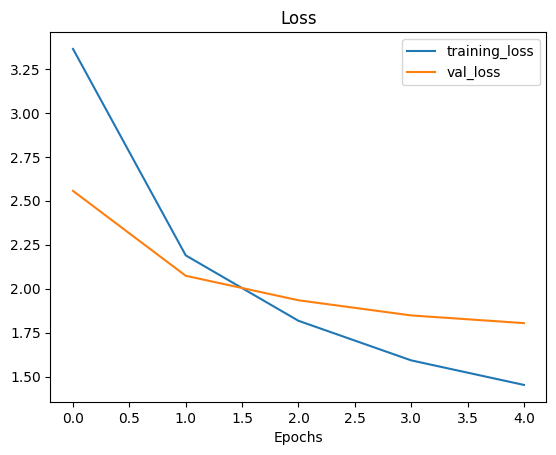

In [11]:
plot_loss_curves(history_all_classes_10_percent)

The diverging loss curves above tell us that the model might be overfitting. We can try fine-tuning to improve the performance of our model.

### Fine Tuning

In [12]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [13]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [14]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [15]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch


Epoch 5/10
237/237 [==============================] - 83s 311ms/step - loss: 1.2157 - accuracy: 0.6822 - val_loss: 1.7522 - val_accuracy: 0.5334
Epoch 6/10
237/237 [==============================] - 68s 287ms/step - loss: 1.0929 - accuracy: 0.7117 - val_loss: 1.7608 - val_accuracy: 0.5320
Epoch 7/10
237/237 [==============================] - 63s 266ms/step - loss: 1.0026 - accuracy: 0.7329 - val_loss: 1.8056 - val_accuracy: 0.5241
Epoch 8/10
237/237 [==============================] - 59s 248ms/step - loss: 0.9464 - accuracy: 0.7501 - val_loss: 1.7555 - val_accuracy: 0.5363
Epoch 9/10
237/237 [==============================] - 55s 232ms/step - loss: 0.8845 - accuracy: 0.7662 - val_loss: 1.7986 - val_accuracy: 0.5315
Epoch 10/10
237/237 [==============================] - 55s 232ms/step - loss: 0.8269 - accuracy: 0.7798 - val_loss: 1.7708 - val_accuracy: 0.5387


In [16]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 58s 73ms/step - loss: 1.5137 - accuracy: 0.5999


[1.5137124061584473, 0.5998811721801758]

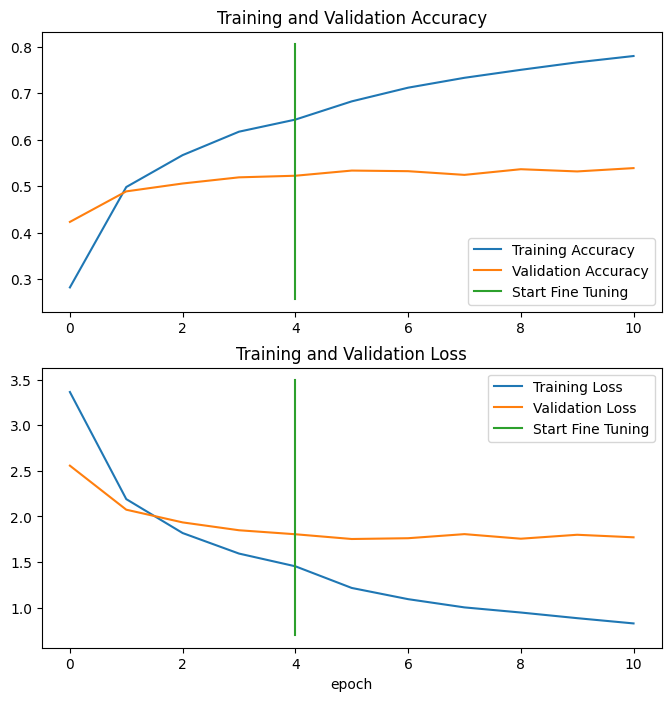

In [17]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

Still diverging lines, the model is overfitting.

In [19]:
model.save("/content/content/Saved_Fine_tuned_Model")

In [20]:
loaded_model = tf.keras.models.load_model("/content/content/Saved_Fine_tuned_Model")

In [21]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 59s 74ms/step - loss: 1.5137 - accuracy: 0.5999


(1.5137124061584473, 0.5998811721801758)

In [24]:
# Make predictions with model
pred_probs = model.predict(test_data)

790/790 [==============================] - 63s 80ms/step


In [25]:
# How many predictions are there?
len(pred_probs)

25250

In [26]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [27]:
# How do they look?
pred_probs[:10]

array([[2.2165206e-01, 5.5508212e-05, 3.8561603e-01, ..., 2.1770897e-05,
        8.9522563e-03, 1.3186463e-02],
       [9.5084894e-01, 6.3270993e-09, 5.1782117e-04, ..., 1.0056326e-03,
        3.1689501e-07, 3.0738652e-06],
       [5.4357040e-01, 1.2729787e-02, 1.4848372e-02, ..., 3.0795357e-04,
        1.1255379e-03, 4.0417262e-03],
       ...,
       [1.6737017e-01, 3.0587694e-06, 2.0182417e-03, ..., 6.6039994e-02,
        1.7146921e-03, 4.6310399e-04],
       [3.6399299e-01, 3.0146391e-04, 2.4834290e-01, ..., 2.7384362e-04,
        4.1238120e-04, 2.7619745e-04],
       [6.3357413e-01, 2.1596023e-07, 1.9982746e-03, ..., 4.6736742e-03,
        3.5337180e-06, 6.6038693e-04]], dtype=float32)

In [28]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 2,  0,  0,  8,  0, 78, 29, 72,  0,  0])

In [30]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [31]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5998811881188119

In [32]:
from helper_functions import make_confusion_matrix
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [33]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.22      0.25       250
           1       0.59      0.69      0.63       250
           2       0.65      0.59      0.62       250
           3       0.89      0.48      0.62       250
           4       0.57      0.38      0.45       250
           5       0.49      0.38      0.43       250
           6       0.71      0.82      0.76       250
           7       0.84      0.76      0.80       250
           8       0.20      0.59      0.30       250
           9       0.40      0.66      0.50       250
          10       0.47      0.49      0.48       250
          11       0.87      0.53      0.66       250
          12       0.77      0.56      0.65       250
          13       0.63      0.46      0.53       250
          14       0.57      0.48      0.52       250
          15       0.33      0.45      0.38       250
          16       0.72      0.53      0.61       250
          17       0.32    

In [35]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.2879581151832461,
  'recall': 0.22,
  'f1-score': 0.24943310657596376,
  'support': 250},
 '1': {'precision': 0.5864406779661017,
  'recall': 0.692,
  'f1-score': 0.6348623853211007,
  'support': 250},
 '2': {'precision': 0.6491228070175439,
  'recall': 0.592,
  'f1-score': 0.6192468619246863,
  'support': 250},
 '3': {'precision': 0.8888888888888888,
  'recall': 0.48,
  'f1-score': 0.6233766233766234,
  'support': 250},
 '4': {'precision': 0.5654761904761905,
  'recall': 0.38,
  'f1-score': 0.45454545454545453,
  'support': 250},
 '5': {'precision': 0.4948453608247423,
  'recall': 0.384,
  'f1-score': 0.43243243243243246,
  'support': 250},
 '6': {'precision': 0.7118055555555556,
  'recall': 0.82,
  'f1-score': 0.762081784386617,
  'support': 250},
 '7': {'precision': 0.8414096916299559,
  'recall': 0.764,
  'f1-score': 0.8008385744234802,
  'support': 250},
 '8': {'precision': 0.2,
  'recall': 0.588,
  'f1-score': 0.2984771573604061,
  'support': 250},
 '9': {'p

In [36]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24943310657596376,
 'baby_back_ribs': 0.6348623853211007,
 'baklava': 0.6192468619246863,
 'beef_carpaccio': 0.6233766233766234,
 'beef_tartare': 0.45454545454545453,
 'beet_salad': 0.43243243243243246,
 'beignets': 0.762081784386617,
 'bibimbap': 0.8008385744234802,
 'bread_pudding': 0.2984771573604061,
 'breakfast_burrito': 0.500763358778626,
 'bruschetta': 0.47749510763209396,
 'caesar_salad': 0.6567164179104478,
 'cannoli': 0.651270207852194,
 'caprese_salad': 0.530232558139535,
 'carrot_cake': 0.5207877461706784,
 'ceviche': 0.3783783783783784,
 'cheese_plate': 0.6129032258064516,
 'cheesecake': 0.3958333333333333,
 'chicken_curry': 0.5,
 'chicken_quesadilla': 0.67420814479638,
 'chicken_wings': 0.7245762711864407,
 'chocolate_cake': 0.5398230088495575,
 'chocolate_mousse': 0.3381642512077295,
 'churros': 0.7209775967413442,
 'clam_chowder': 0.688034188034188,
 'club_sandwich': 0.6774847870182557,
 'crab_cakes': 0.35276073619631904,
 'creme_brulee': 0.7594936708860

In [37]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33    edamame  0.964567
63   macarons  0.909474
69    oysters  0.860000
75        pho  0.855446
32  dumplings  0.846774

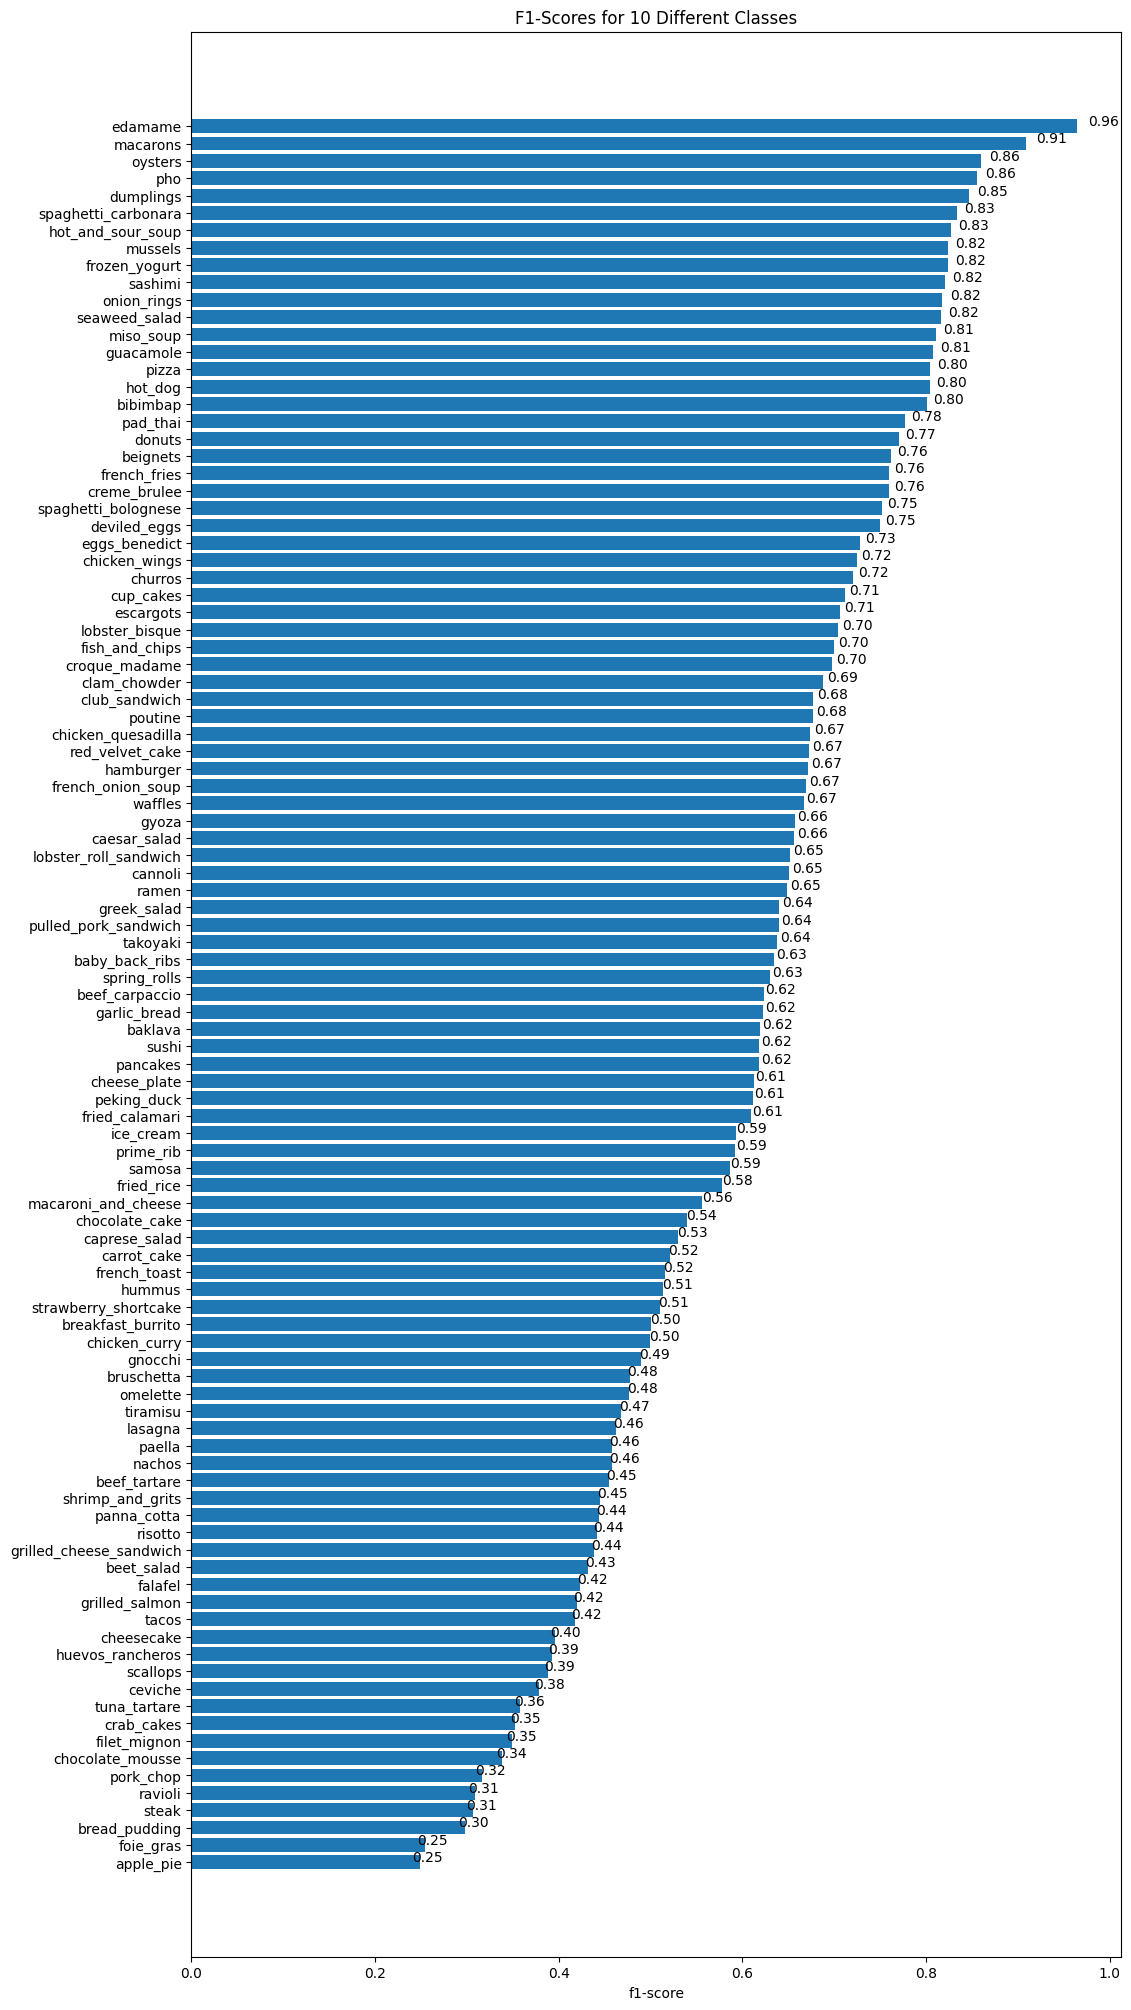

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

1/1 [==============================] - 0s 31ms/step


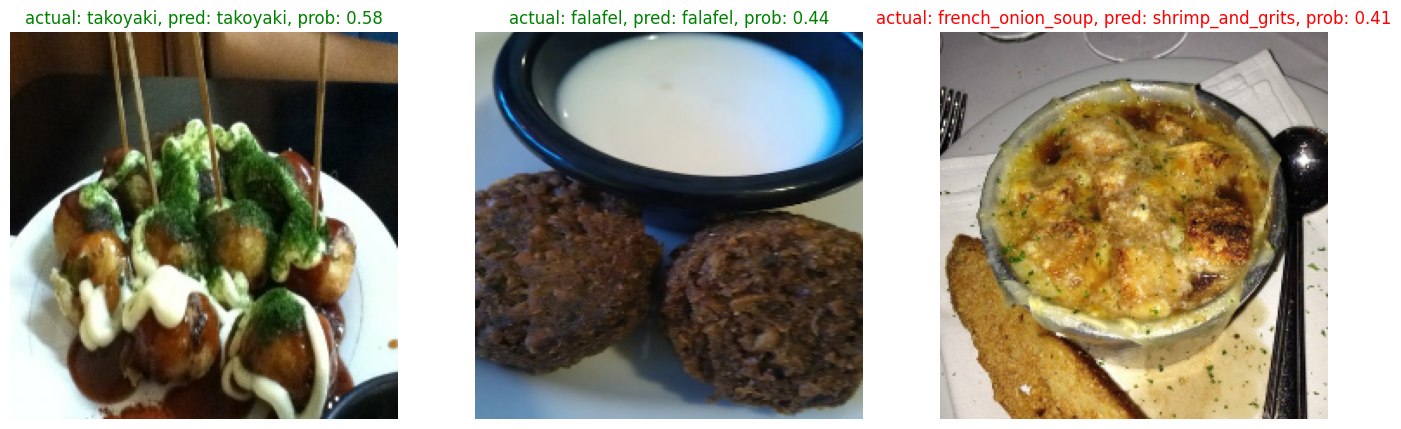

In [40]:
# Make preds on a series of random images
import os
import random
from helper_functions import load_and_prep_image

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [41]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [42]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   

   pred_conf y_true_classname y_pred_classname  
0   0.385616        apple_pie          baklava  
1   0.950849        apple_pie        apple_pie  
2   0.543570        apple_pie        apple_pie  
3   0.317616        apple_pie    bread_pudding  
4   0.364998        apple_pie        apple_pie

In [43]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.385616        apple_pie          baklava         False  
1   0.950849        apple_pie        apple_pie          True  
2   0.543570        apple_pie        apple_pie          True  
3   0.317616        apple_pie    bread_pudding         False  
4   0.364998        apple_pie        apple_pie          True

In [44]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
9110   b'101_food_classes_10_percent/test/falafel/241...      36      31   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   
14255  b'101_food_classes_10_percent/test/hummus/1071...      57      49   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
16271  b'101_food_classes_10_percent/test/mussels/140...      65      69   
14691  b'101_food_classes_10_percent/test/ice_cream/3...      58      79   
10777  b'101_food_classes_10_percent/test/fried_calam...      43      68   
7295   b'101_food_classes_10_percent/test/cup_cakes/1...      29      31   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
11898  b'101_food_classes_10_percent/test/gnocchi/340...      47      87   
5849   b'101_food_classes_10_percent/test/churros/254...      23      68   
21652  b'101_food_classes_10_percent/test/sashimi/306...      86      95   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
5572   b'101_food_classes_10_percent/test/chocolate_m...      22      79   
4583   b'101_food_classes_10_percent/test/chicken_cur...      18      60   

       pred_conf  y_true_classname         y_pred_classname  pred_correct  
10847   0.999027    fried_calamari              onion_rings         False  
18001   0.998529          pancakes                 omelette         False  
11642   0.997275      garlic_bread               bruschetta         False  
23797   0.996761             sushi                  sashimi         False  
9110    0.996505           falafel                   donuts         False  
10854   0.996206    fried_calamari              onion_rings         False  
10880   0.995723    fried_calamari              onion_rings         False  
14255   0.995617            hummus  grilled_cheese_sandwich         False  
5114    0.995384     chicken_wings           fish_and_chips         False  
16271   0.995050           mussels                  oysters         False  
14691   0.994729         ice_cream                prime_rib         False  
10777   0.994722    fried_calamari              onion_rings         False  
7295    0.994318         cup_cakes                   donuts         False  
17855   0.994177            paella                  mussels         False  
11898   0.994129           gnocchi                 scallops         False  
5849    0.993881           churros              onion_rings         False  
21652   0.993473           sashimi                    sushi         False  
8794    0.993210         escargots        french_onion_soup         False  
5572    0.993199  chocolate_mousse                prime_rib         False  
4583    0.991938     chicken_curry           lobster_bisque         False

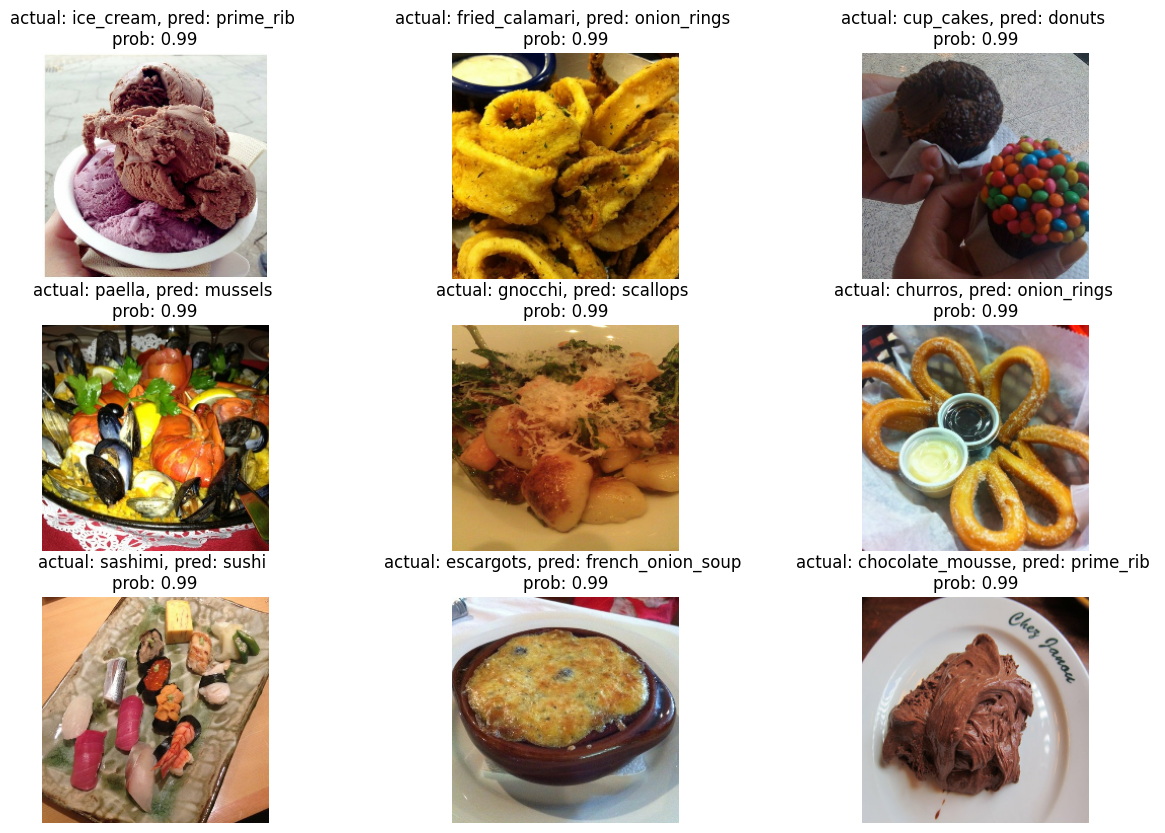

In [45]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [46]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-01-12 14:31:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.06s   

2024-01-12 14:31:53 (194 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [47]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 29ms/step


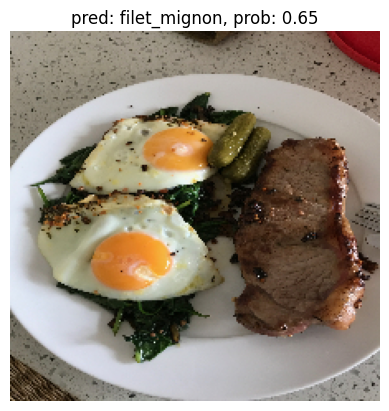

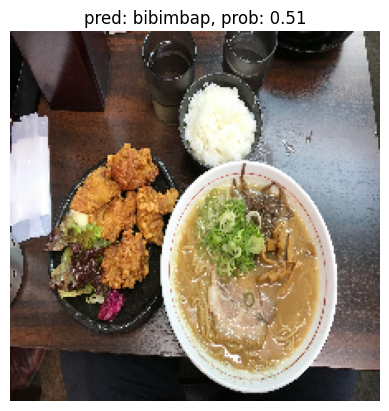

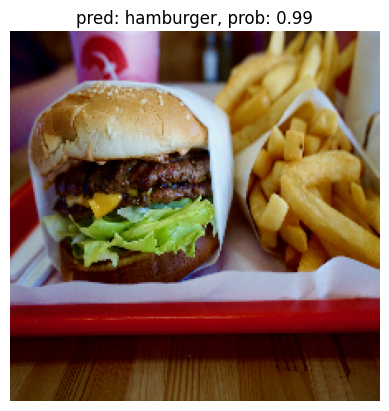

In [48]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)